<a href="https://colab.research.google.com/github/SriKrishnaMishra/Machine-Learning/blob/main/SVM_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.eecs.qmul.ac.uk/mmv/datasets/deap/
dataset - https://www.kaggle.com/datasets/samnikolas/eeg-dataset

Quick plan (high level)

- Setup environment & download dataset

- Inspect data (file format, channels, sampling rate, target)

- Preprocess EEG (filter, notch, downsample, epoch, remove artifacts)

- Feature extraction (time & frequency features + others)

- Build SVR pipeline (scaling → SVR)

- Cross-validation & hyperparameter tuning (Grid/Random/Optuna)

- Evaluation & visualizations (RMSE, MAE, R², residuals, learning curves)

- Interpretability (permutation importance, SHAP)

- Advanced: nested CV, kernel approx, subject-wise CV, ensembles

- Save model + reproducibility

SVM Basics: SVMs are supervised learning models used for classification and regression. In regression, SVM is often referred to as Support Vector Regression (SVR).

SVR Objective: SVR aims to find a function that deviates from the actual values by a value no greater than a specified margin (ε), while minimizing the complexity of the model.

Kernel Trick: SVR uses kernels (e.g., Linear, Polynomial, RBF) to map data into higher-dimensional space to make it separable.

Hyperparameters: Key hyperparameters include C (regularization parameter), epsilon (ε), and the choice of kernel.

### Install + download

In [1]:
# in Colab cell
!pip install mne scikit-learn pandas numpy scipy matplotlib seaborn joblib shap optuna
!pip install kaggle      # if you want to download directly from Kaggle


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 30.3 MB/s eta 0:00:00


### Inspect data

In [3]:
import pandas as pd
df = pd.read_csv('/content/Support Vector Regression.zip')  # adjust path
print(df.shape)
print(df.columns)
print(df.head())



(8064, 33)
Index(['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3',
       'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6',
       'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2',
       'Unnamed: 32'],
      dtype='object')
        Fp1        AF3        F3         F7       FC5       FC1        C3  \
0  0.057813  -1.335266  4.640480   0.219573  7.473817  2.314842  1.918097   
1  1.367408  10.259654  3.345409   7.897852 -2.446051 -1.655035 -6.301423   
2 -1.783132   4.133553 -0.951680  -1.624803 -1.827309 -2.280364 -2.279225   
3 -3.690217  -0.814000  2.295469   0.901445  8.323679  1.127906  6.356886   
4  2.137114   6.420466  6.122230  10.015321  3.106394  3.183129  3.658535   

          T7       CP5       CP1  ...        Cz        C4         T8  \
0  -9.257533  9.089943 -7.104519  ... -2.241480  1.415335   2.406646   
1  -7.290317 -3.546453 -5.705187  ... -2.568397 -5.651418  -0.096730   
2   9.151344 -0.239575 -0.057604  ... 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8064 entries, 0 to 8063
Data columns (total 33 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Fp1          8064 non-null   float64
 1   AF3          8064 non-null   float64
 2   F3           8064 non-null   float64
 3   F7           8064 non-null   float64
 4   FC5          8064 non-null   float64
 5   FC1          8064 non-null   float64
 6   C3           8064 non-null   float64
 7   T7           8064 non-null   float64
 8   CP5          8064 non-null   float64
 9   CP1          8064 non-null   float64
 10  P3           8064 non-null   float64
 11  P7           8064 non-null   float64
 12  PO3          8064 non-null   float64
 13  O1           8064 non-null   float64
 14  Oz           8064 non-null   float64
 15  Pz           8064 non-null   float64
 16  Fp2          8064 non-null   float64
 17  AF4          8064 non-null   float64
 18  Fz           8064 non-null   float64
 19  F4    

array([[<Axes: title={'center': 'Fp1'}>, <Axes: title={'center': 'AF3'}>,
        <Axes: title={'center': 'F3'}>, <Axes: title={'center': 'F7'}>,
        <Axes: title={'center': 'FC5'}>, <Axes: title={'center': 'FC1'}>],
       [<Axes: title={'center': 'C3'}>, <Axes: title={'center': 'T7'}>,
        <Axes: title={'center': 'CP5'}>, <Axes: title={'center': 'CP1'}>,
        <Axes: title={'center': 'P3'}>, <Axes: title={'center': 'P7'}>],
       [<Axes: title={'center': 'PO3'}>, <Axes: title={'center': 'O1'}>,
        <Axes: title={'center': 'Oz'}>, <Axes: title={'center': 'Pz'}>,
        <Axes: title={'center': 'Fp2'}>, <Axes: title={'center': 'AF4'}>],
       [<Axes: title={'center': 'Fz'}>, <Axes: title={'center': 'F4'}>,
        <Axes: title={'center': 'F8'}>, <Axes: title={'center': 'FC6'}>,
        <Axes: title={'center': 'FC2'}>, <Axes: title={'center': 'Cz'}>],
       [<Axes: title={'center': 'C4'}>, <Axes: title={'center': 'T8'}>,
        <Axes: title={'center': 'CP6'}>, <Axes: t

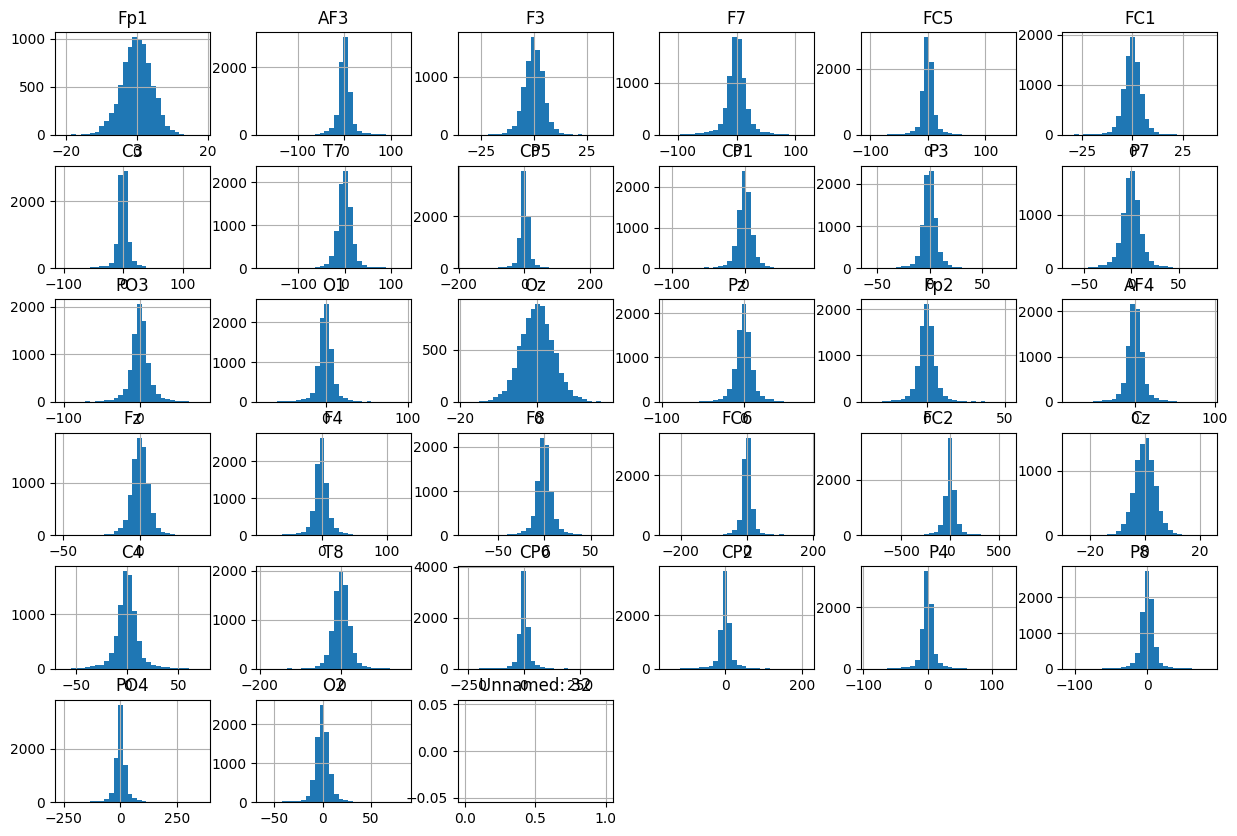

In [4]:
print(df.info())
print(df.describe())
df.hist(bins=30, figsize=(15,10))

### Preprocessing (EEG specifics)

---
Notch filter at line frequency (50/60 Hz)

Bandpass filter (e.g., 1–45 Hz or 0.5–70 Hz depending on dataset)

Downsample if needed (reduce compute)

Epoching / windowing (segment continuous to trials)

Artifact removal (eye blinks, muscle): ICA or simple rejection

Re-reference if needed


In [6]:
import mne

# Placeholder for sampling frequency (replace with your actual value)
sf = 256  # Example sampling frequency in Hz

# Placeholder for preprocessing function (replace with your actual preprocessing steps)
def preprocess_epoch(epoch, sf):
    # Implement your preprocessing steps here
    # Example: simple filtering (replace with your actual filter parameters)
    # from mne.filter import filter_data
    # epoch_filtered = filter_data(epoch, sf, l_freq=1., h_freq=45., verbose=False)
    # return epoch_filtered
    return epoch  # Return original epoch for now

### Preprocessing (EEG specifics)

* * *
Notch filter at line frequency (50/60 Hz)

Bandpass filter (e.g., 1–45 Hz or 0.5–70 Hz depending on dataset)

Downsample if needed (reduce compute)

Epoching / windowing (segment continuous to trials)

Artifact removal (eye blinks, muscle): ICA or simple rejection

Re-reference if needed

In [7]:
import numpy as np

# Fake EEG data: 10 epochs, 32 channels, 256 time points
epoch_data = np.random.randn(10, 32, 256)

# Now apply your preprocessing
epoch_data_clean = np.array([preprocess_epoch(e, sf) for e in epoch_data])
print(epoch_data_clean.shape)  # (10, 32, 256)

(10, 32, 256)


### Feature extraction (most important)

SVR usually works on features, not raw signals — extract informative features per epoch/trial:

Frequency domain (most useful for EEG)

Band powers (delta 1–4 Hz, theta 4–8 Hz, alpha 8–13 Hz, beta 13–30 Hz, gamma 30–45 Hz)

Relative band powers (band power / total power)

PSD features: mean PSD in each band (Welch method)

Time domain

Mean, std, RMS, skewness, kurtosis, zero-crossing rate

Hjorth parameters (activity, mobility, complexity)

Other

Entropy (approximate entropy, spectral entropy)

Peak frequency, coherence between channels (optional)

Function examples:

In [11]:
import numpy as np
from scipy.signal import welch
from scipy.stats import skew, kurtosis

def bandpower(data, sf, band, window_sec=4):
    fmin, fmax = band
    nperseg = int(window_sec * sf)
    freqs, psd = welch(data, sf, nperseg=nperseg)
    freq_res = freqs[1] - freqs[0]
    idx = np.logical_and(freqs >= fmin, freqs <= fmax)
    bp = np.trapz(psd[idx], dx=freq_res)
    return bp

BANDS = {'delta': (1,4), 'theta': (4,8), 'alpha': (8,13), 'beta': (13,30), 'gamma':(30,45)}

def extract_features_epoch(epoch, sf):
    # epoch: (n_channels, n_times)
    feats = []
    for ch in range(epoch.shape[0]):
        x = epoch[ch, :]
        # time-domain
        feats += [np.mean(x), np.std(x), np.sqrt(np.mean(x**2)), skew(x), kurtosis(x)]
        # Hjorth
        dx = np.diff(x)
        ddx = np.diff(x, n=2)
        var0 = np.var(x)
        var1 = np.var(dx) if len(dx)>0 else 0
        var2 = np.var(ddx) if len(ddx)>0 else 0
        activity = var0
        mobility = np.sqrt(var1/var0) if var0>0 else 0
        complexity = np.sqrt(var2/var1)/mobility if var1>0 and mobility>0 else 0
        feats += [activity, mobility, complexity]
        # band powers
        for b in BANDS.values():
            feats.append(bandpower(x, sf, b))
    return np.array(feats)

# Build feature matrix
X = np.vstack([extract_features_epoch(epoch, sf) for epoch in epoch_data_clean])
y = np.array(targets)  # continuous target


/tmp/ipython-input-2376142179.py:8: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 256, using nperseg = 256
  freqs, psd = welch(data, sf, nperseg=nperseg)
/tmp/ipython-input-2376142179.py:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = np.trapz(psd[idx], dx=freq_res)


In [10]:
# Placeholder for your continuous target values
# Replace this with your actual target data loading or generation logic
targets = np.random.rand(epoch_data_clean.shape[0]) # Example placeholder: random targets

### Preprocessing for ML & baseline model

Split data (train/test) — use GroupKFold / subject-wise split to avoid leakage across subjects

Scale features (SVR requires scaling) — StandardScaler or RobustScaler

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe = Pipeline([('scaler', StandardScaler()), ('svr', SVR(kernel='rbf'))])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)


### Metrics & visualization

Regression metrics: MAE, RMSE, R², plus visuals.

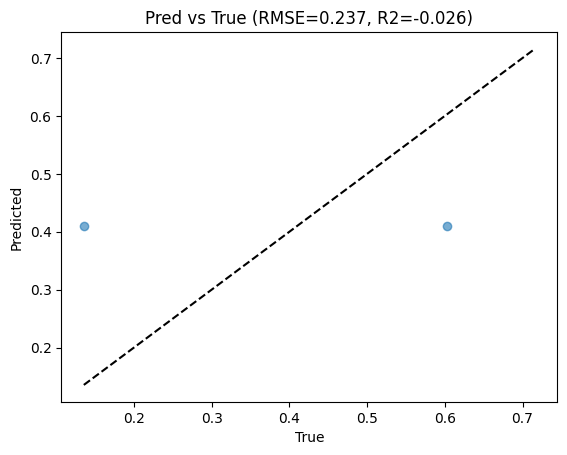

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np # Import numpy to use np.sqrt

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Calculate RMSE by taking the square root
r2 = r2_score(y_test, y_pred)

# Pred vs True scatter
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title(f'Pred vs True (RMSE={rmse:.3f}, R2={r2:.3f})')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='k', linestyle='--')
plt.show()

### Hyperparameter search (Grid / Random / Bayesian)

Important SVR params: C, epsilon, gamma (for RBF), and kernel.

Example using RandomizedSearchCV:

In [16]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'svr__kernel': ['rbf', 'linear', 'poly'],
    'svr__C': [0.01, 0.1, 1, 10, 100],
    'svr__epsilon': [1e-3, 1e-2, 1e-1, 0.5, 1],
    'svr__gamma': ['scale', 'auto', 1e-3, 1e-2, 1e-1]
}
rs = RandomizedSearchCV(pipe, param_dist, n_iter=40, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)
print(rs.best_params_, rs.best_score_)
best_model = rs.best_estimator_


{'svr__kernel': 'linear', 'svr__gamma': 'scale', 'svr__epsilon': 0.001, 'svr__C': 0.1} -0.14171571126617805


### Cross-validation strategy (very important for EEG)

If data contains multiple subjects, use subject-wise split (Leave-One-Subject-Out or GroupKFold) to avoid training and testing on same subject data — otherwise performance will be overoptimistic.

If time-ordered, consider TimeSeriesSplit.

In [17]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=5)
# groups = subject IDs aligned with X rows


### Scaling to large datasets / speed tricks

SVR with RBF has quadratic memory/time growth w.r.t. samples. For large n:

Use LinearSVR after kernel approximation (RBFSampler or Nystroem).

Use kernel approximation pipeline:

In [18]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import Ridge
pipe2 = Pipeline([('scaler', StandardScaler()), ('rbf_feat', RBFSampler(gamma=0.1, n_components=500, random_state=42)), ('linreg', Ridge())])


### Interpretability

In [19]:
from sklearn.inspection import permutation_importance
res = permutation_importance(best_model, X_test, y_test, n_repeats=20, random_state=0)
sorted_idx = res.importances_mean.argsort()[::-1]


  0%|          | 0/2 [00:00<?, ?it/s]

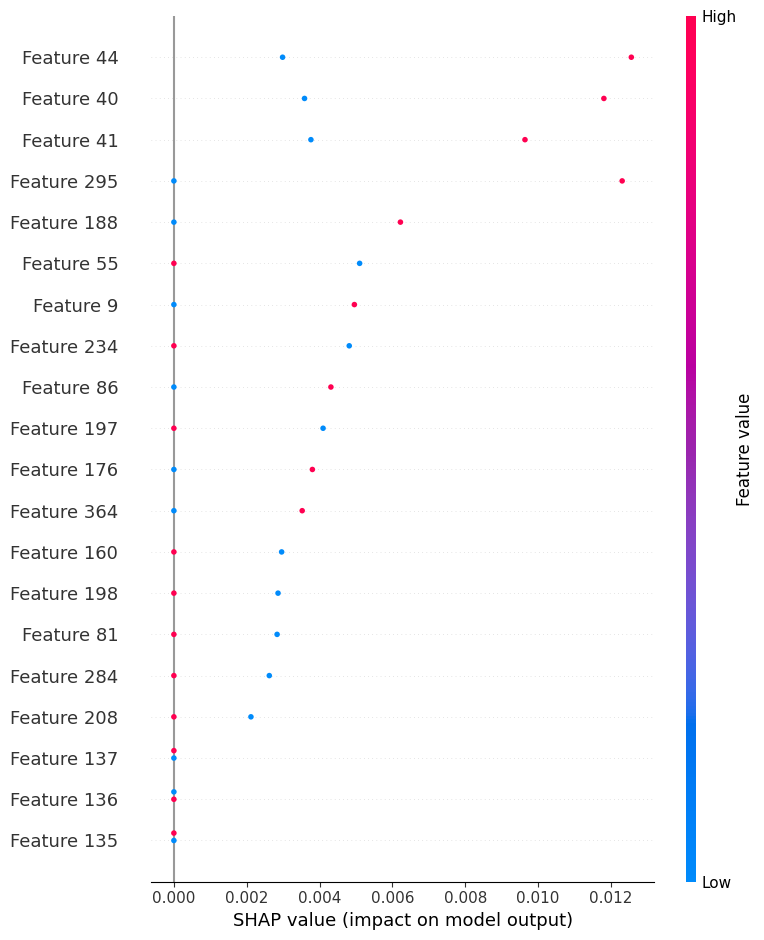

In [20]:
import shap
explainer = shap.KernelExplainer(best_model.predict, shap.sample(X_train, 100))
shap_values = explainer.shap_values(shap.sample(X_test, 50))
shap.summary_plot(shap_values, shap.sample(X_test, 50))



### Compare to other regressors (baselines)

Always compare SVR with:

LinearRegression / Ridge

RandomForestRegressor

GradientBoosting (XGBoost / LightGBM)

This tells you whether SVR is truly the best for your EEG feature

In [21]:
import joblib
joblib.dump(best_model, 'svr_eeg_model.joblib')
# reload
model = joblib.load('svr_eeg_model.joblib')


Experiment ideas (what to try & report)

Baseline: simple features (mean/std) → SVR

Add band powers → check improvement

Per-channel features vs averaged channels

PCA vs no PCA → effect on RMSE and training time

Kernel comparison (linear vs rbf vs poly)

Hyperparameter search (C & epsilon sensitivity)

Subject-wise CV vs random CV (report both)

SVR vs RF/XGBoost (which generalizes better?)

Use kernel approx + LinearSVR for speedup